# Rotating Rasters with Rasetio and Python 

In [ ]:
from landsatxplore.api import API
import matplotlib.pyplot as plt
import rasterio as rio
import os

dp = os.environ.get('pub_data')
ls_data = dp + 'landsat_data/'

In [4]:
# ID of the raster we want to open
ID = "LC08_L2SP_175083_20230418_20230429_02_T1"

(7711, 7651)


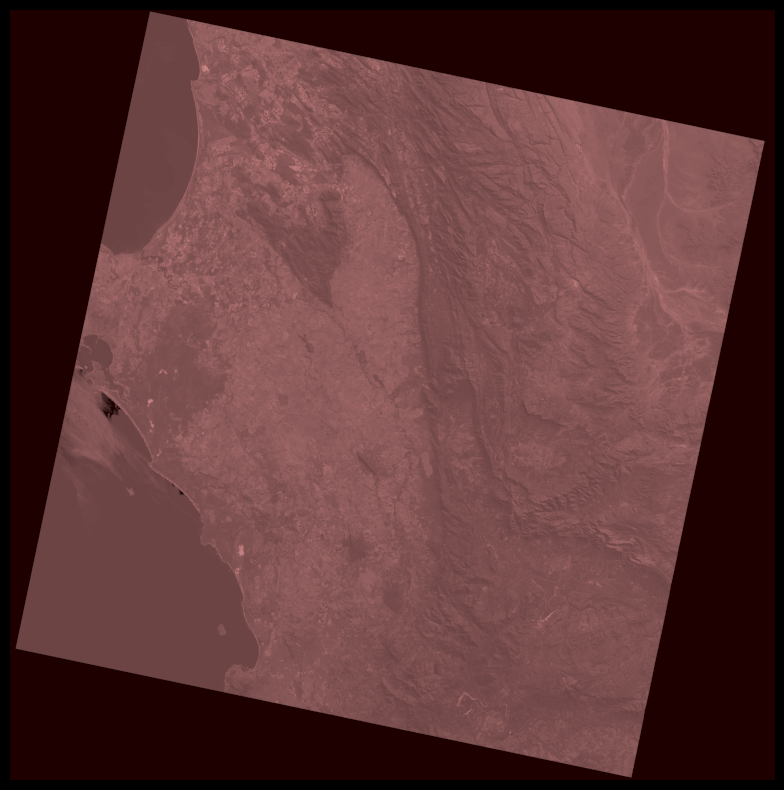

In [5]:
# Open the red band (B4):
B4 = rio.open(ls_data + '{}/{}_SR_B4.TIF'.format(ID, ID))

print(B4.shape)

# Display the band
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(B4.read(1), cmap='pink')

ax.set_axis_off()

In [17]:
print(B4.crs) # Gives coordinate reference system
print(B4.transform) # Affine transformation matrix

# convert array positions to UTM coordinates
x,y = (1000,2000)
utmx,utmy = B4.xy(y,x)
print("\n"+ str((utmx,utmy))) 

EPSG:32634
| 29.34,-6.24, 214857.80|
|-6.24,-29.34,-3540586.31|
| 0.00, 0.00, 1.00|

(231739.0824319788, -3605530.308477244)


In [6]:
from rasterio.warp import reproject, Resampling
from affine import Affine
import numpy as np

def rotate_raster(in_file,out_file, angle, shift_x=0, shift_y=0,adj_width=0, adj_height=0):
    """Rotate a raster image and save it to disk.
            in_file: path to input raster file
            out_file: path to output raster file
            angle: angle of rotation in degrees
            shift_x: shift in x direction
            shift_y: shift in y direction
            adj_width: adjust width of output raster
            adj_height: adjust height of output raster"""

    with rio.open(in_file) as src:

        # Get the old transform and crs
        src_transform = src.transform 
        crs = src.crs

        # Affine transformations for rotation and translation
        rotate = Affine.rotation(angle)
        trans_x = Affine.translation(shift_x,0)
        trans_y = Affine.translation(0, -shift_y)

        # Combine affine transformations
        dst_transform = src_transform * rotate * trans_x * trans_y

        # Get band data
        band = np.array(src.read(1))

        # Get the new shape
        y,x = band.shape
        dst_height = y + adj_height
        dst_width = x + adj_width

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update(
            {
                "transform": dst_transform,
                "height": dst_height,
                "width": dst_width,
                "nodata": 0,  
            }
        )

        # write to disk
        with rio.open(out_file, "w", **dst_kwargs) as dst:
            # reproject to new CRS

            reproject(source=band,
                        destination=rio.band(dst, 1),
                        src_transform=src_transform,
                        src_crs=crs,
                        dst_transform=dst_transform,
                        dst_crs=crs,
                        resampling=Resampling.nearest)

(7711, 7651)


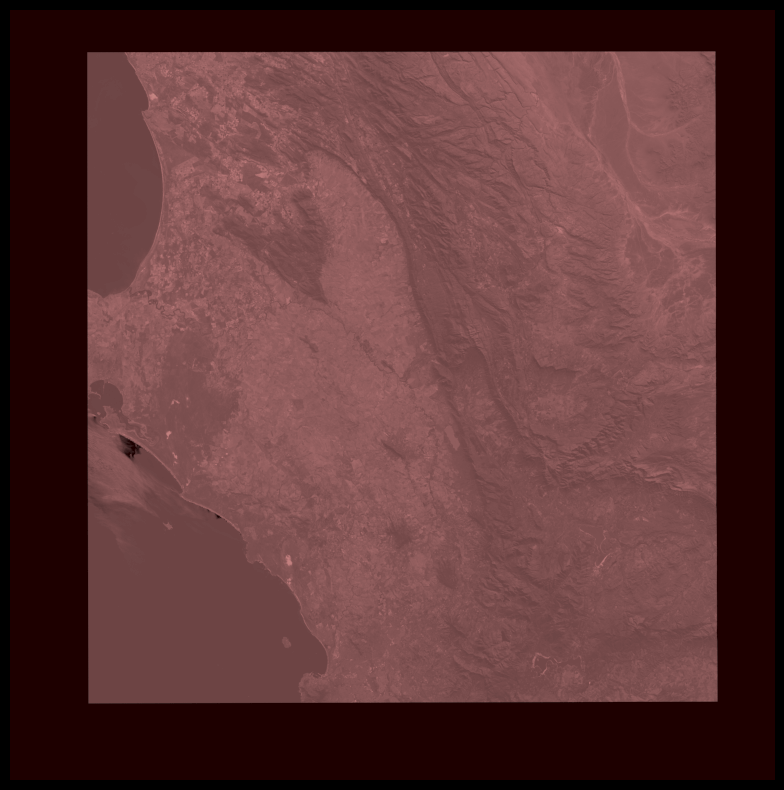

In [7]:
file = ls_data + '{}/{}_SR_B4.TIF'.format(ID, ID)
out_file = ls_data + '{}/{}_SR_B4_rotated.TIF'.format(ID, ID)

rotate_raster(file,out_file, 12, shift_x=600, shift_y=700)

# Open the red band (B4):
B4 = rio.open(out_file)

print(B4.shape)

# Display the band
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(B4.read(1), cmap='pink')

ax.set_axis_off()


## Effects of shifting

In [8]:
out_file = ls_data + '{}/{}_SR_B4_noshift.TIF'.format(ID, ID)

rotate_raster(file,out_file, 12)

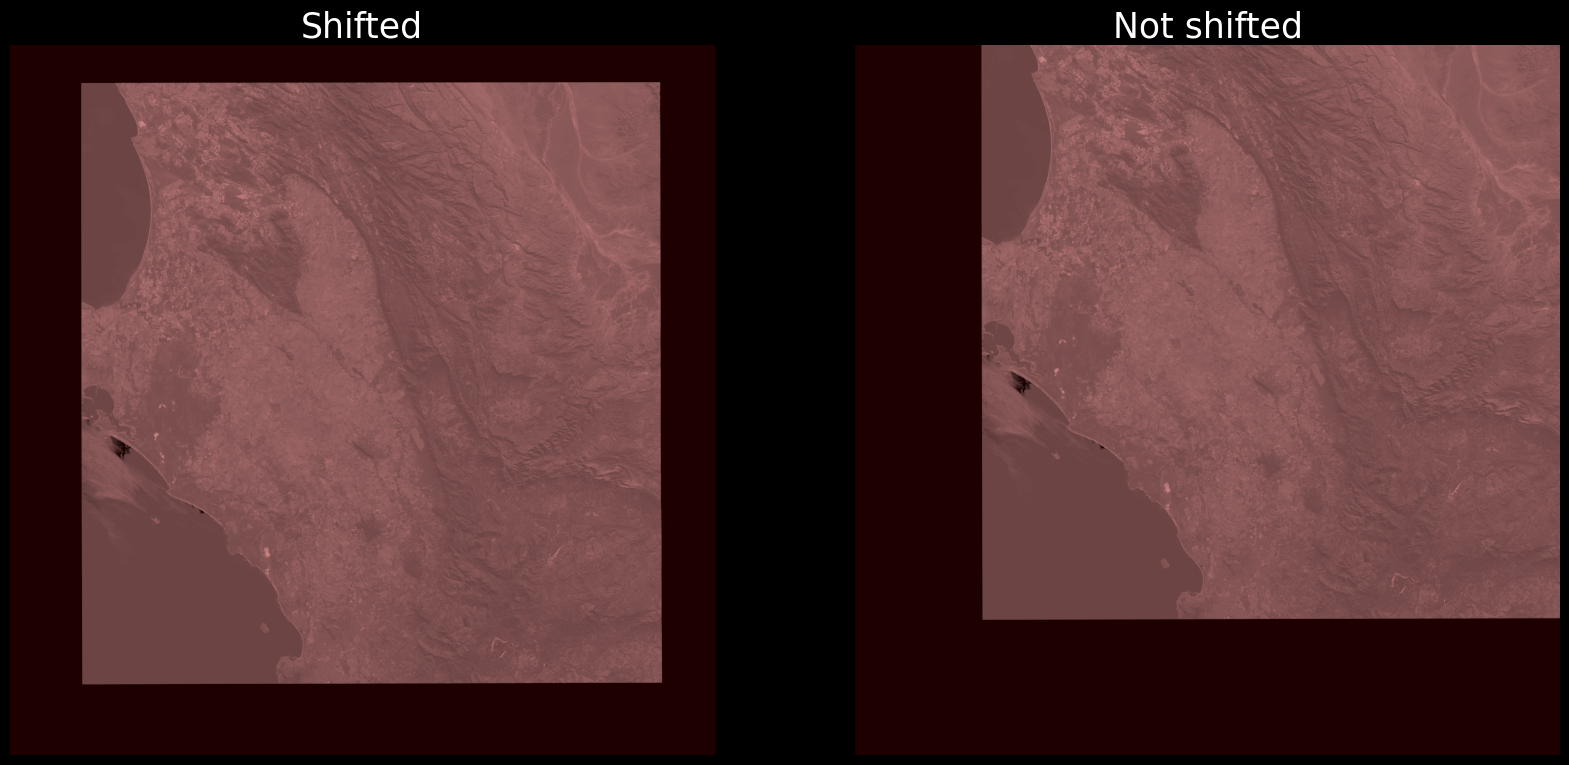

In [9]:
file1 = ls_data + '{}/{}_SR_B4_rotated.TIF'.format(ID, ID)
file2 = ls_data + '{}/{}_SR_B4_noshift.TIF'.format(ID, ID)

# Open the red band (B4):
B4 = rio.open(file1)
B4_noshift = rio.open(file2)

# Display the bands

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))

ax1.imshow(B4.read(1), cmap='pink')
ax1.set_title('Shifted', fontsize=25)
ax1.set_axis_off()

ax2.imshow(B4_noshift.read(1), cmap='pink')
ax2.set_title('Not shifted', fontsize=25)
ax2.set_axis_off()

## Effects of dimension adjustment

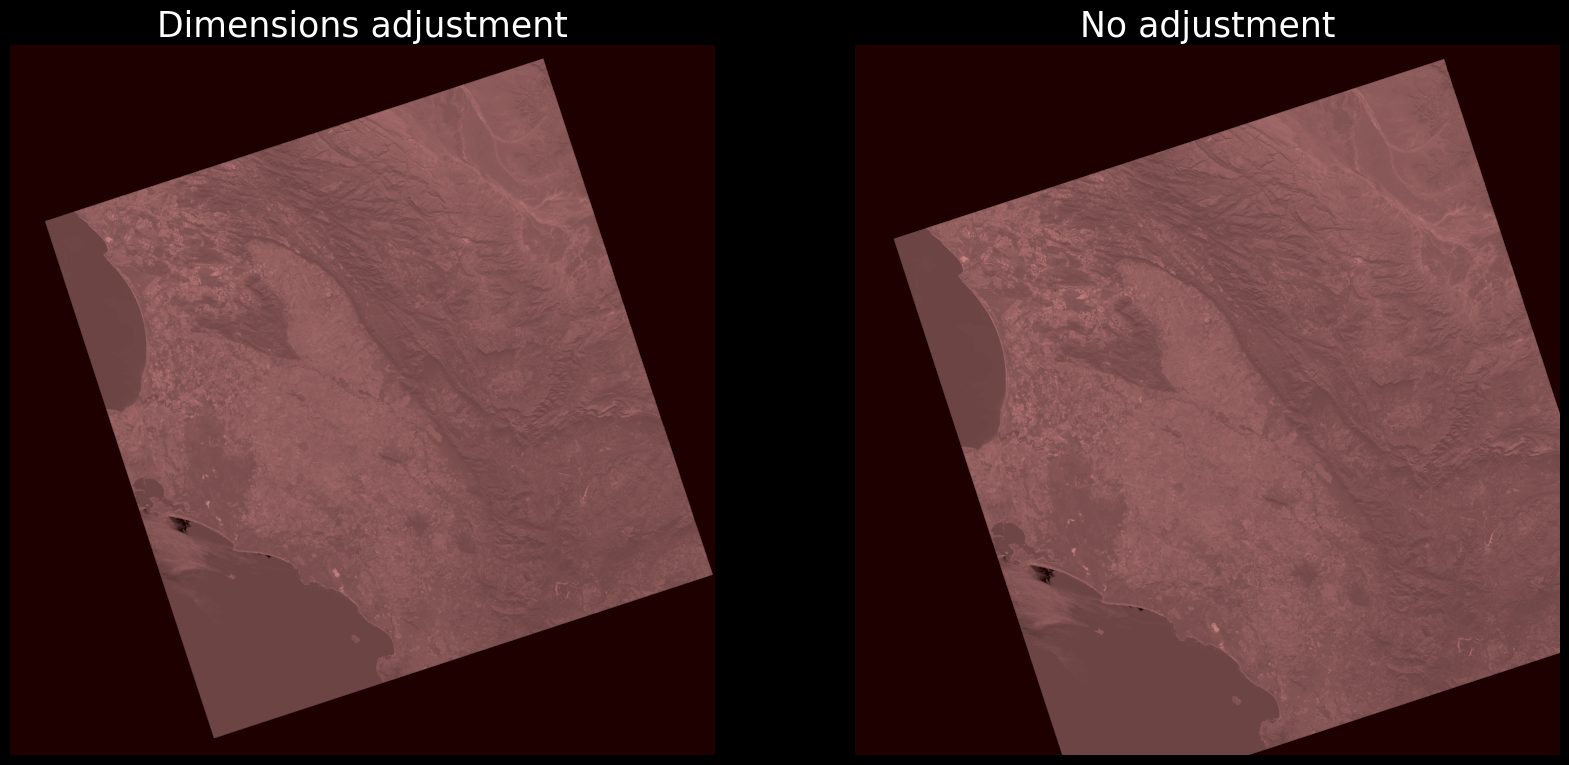

In [10]:
#With dimensions adjustment
out_file_1 = ls_data + '{}/{}_SR_B4_adjust.TIF'.format(ID, ID)
rotate_raster(file,out_file_1, 30,800,2800,adj_width=800, adj_height=800)

#Without dimensions adjustment
out_file_2 = ls_data + '{}/{}_SR_B4_noadjust.TIF'.format(ID, ID)
rotate_raster(file,out_file_2, 30,800,2800)

# Open the red band (B4):
B4_adjust = rio.open(out_file_1)
B4_noadjust = rio.open(out_file_2)

# Display the bands
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))

ax1.imshow(B4_adjust.read(1), cmap='pink')
ax1.set_title('Dimensions adjustment', fontsize=25)
ax1.set_axis_off()

ax2.imshow(B4_noadjust.read(1), cmap='pink')
ax2.set_title('No adjustment', fontsize=25)
ax2.set_axis_off()

## sense check the coordinates

In [11]:
import json 

STAC = json.load(open(ls_data + '{}/{}_SR_stac.json'.format(ID, ID)))
geometry = STAC['geometry']
geometry

{'type': 'Polygon',
 'coordinates': [[[18.190191571987818, -32.12577247238708],
   [17.69978688593541, -33.83926094601545],
   [19.68928305963298, -34.22548931958983],
   [20.140523910811762, -32.505326664084606],
   [18.190191571987818, -32.12577247238708]]]}

In [13]:
import utm 

file1 = ls_data + '{}/{}_SR_B4_rotated.TIF'.format(ID, ID)
B4 = rio.open(file1)

utm_coords = []
pixel_coords = []

for coord in geometry['coordinates'][0]:
    lon = coord[0]
    lat = coord[1]

    utmx, utmy, _, _ = utm.from_latlon(lat, lon, force_zone_number=34, force_zone_letter='N') 

    # Remove false northing
    if lat< 0:
        utmy = utmy - 10000000
    """if lat < 0:
        utmx = utmx - 500000"""

    y,x = B4.index(utmx, utmy)
    pixel_coords.append([x,y])

    utm_coords.append([utmx, utmy])

print(pixel_coords)

[[773, 423], [785, 6943], [7075, 6925], [7054, 415], [773, 423]]


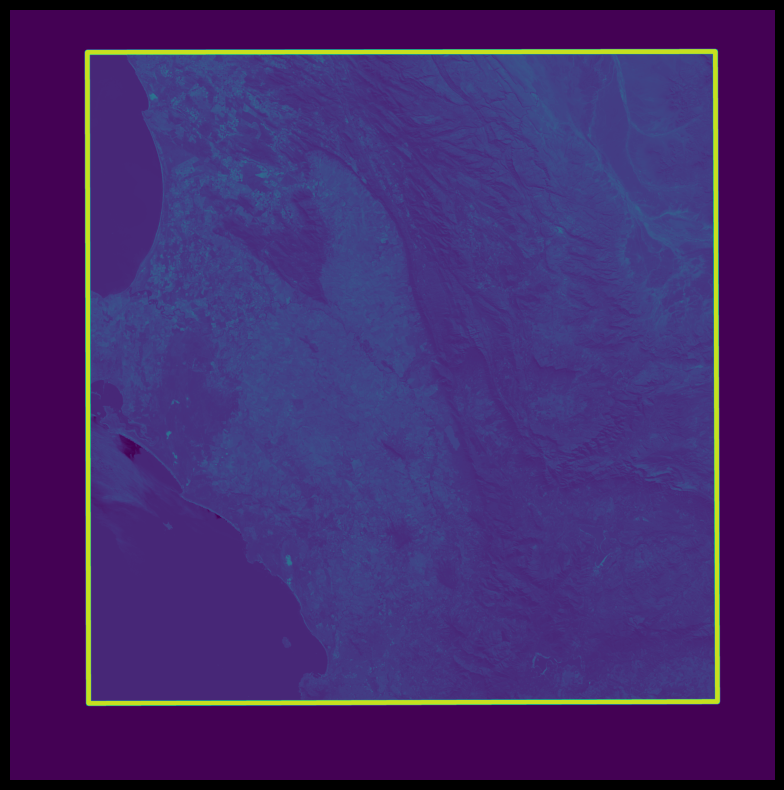

In [14]:
import cv2

fig, ax = plt.subplots(figsize=(10,10))

file1 = ls_data + '{}/{}_SR_B4_rotated.TIF'.format(ID, ID)

B4_ = B4.read(1)

# draw box aroudn scene
for i in range(len(pixel_coords)-1):
    x1,y1 = pixel_coords[i]
    x2,y2 = pixel_coords[i+1]

    B4_ = cv2.line(B4_, (x1,y1), (x2, y2),60000,50)

# Plot points on RGB image
plt.imshow(B4_)
ax.set_axis_off()

In [15]:
from rasterio import mask

# Open the red band (B4):
B4 = rio.open(file1)

# Create a polygon geometry from utm coordinates
geometry = {'type': 'Polygon', 'coordinates': [utm_coords]}


# Clip the raster with polygon
out_image, out_transform = mask.mask(B4, [geometry], crop=True)

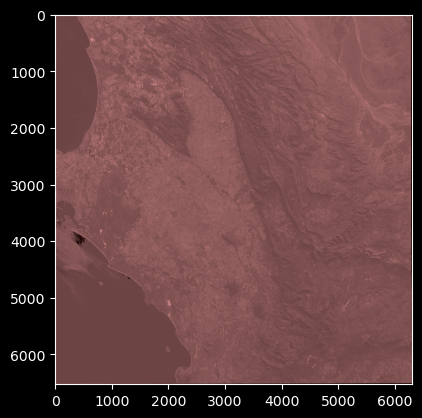

In [16]:
plt.imshow(out_image[0], cmap='pink')